## HW3 KMeans
106062314 蔡政諺

## Import libraries and define global variables
$max$_$iter$: number of iterations<br>
$index$: index of centroids/datapoints

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from pyspark import SparkConf, SparkContext

max_iter = 20
index = 0

## Functions

### calc_dist
Calculate Euclidean/Manhattan distance between $c1$ and $c2$.<br>
$c1$ and $c2$ are list of floats with the same length.

In [2]:
def calc_dist(c1, c2, metric):
    dist = 0.0
    dim = len(c1)
    for i in range(dim):
        if metric == "euclidean":
            dist += (c1[i] - c2[i]) ** 2
        elif metric == "manhattan":
            dist += abs(c1[i] - c2[i])
    return dist

### plot_costs
(1) Display a table of costs vs. iterations.<br>
(2) Plot a line graph of costs vs. iterations.

In [3]:
def plot_costs(costs_c1, costs_c2):
    columns = ["C1", "C2"]
    rows = []
    for i in range(max_iter):
        rows.append("Round " + str(i+1))
    df = pd.DataFrame(list(zip(costs_c1, costs_c2)), columns=columns, index=rows)
    display(df)
    
    X = np.arange(1, max_iter+1)
    plt.plot(X, costs_c1, color='blue', label='C1')
    plt.plot(X, costs_c2, color='orange', label='C2')
    plt.xlabel('iteration', fontsize=14)
    plt.ylabel('cost', fontsize=14)
    plt.ylim(bottom=0)
    plt.xticks(X)
    plt.legend(loc='upper right')
    plt.grid(axis='y')
    plt.show()
    return

### calc_improvement
Return the percentage improvement of cost.

In [4]:
def calc_improvement(costs):
    return abs(costs[-1]-costs[0])/costs[0] * 100

### create_table
Display a table of Euclidean/Manhattan distances between centroids.

In [5]:
def create_table(centroids, metric):
    k = len(centroids)
    table = np.zeros(shape=(k, k))
    for i in range(k):
        for j in range(k):
            if i < j:
                table[i][j] = calc_dist(centroids[i][1], centroids[j][1], metric=metric)
                if metric == "euclidean":
                    table[i][j] = math.sqrt(table[i][j])
    df = pd.DataFrame(table)
    for i in range(k):
        df[i][i+1:] = ''
    df.columns = np.arange(1, k+1)
    df.index = np.arange(1, k+1)
    display(df)
    return

## Mappers and reducers

### mapper1
Split the contents in the input file, and convert them into key-value pairs.<br>
#### input
$lines$: lines of the input file
#### output
$key$: index of the point (start at 1)<br>
$value$: list of floats (each float number denotes a feature of a certain dimension)
#### example
```"100 200 300\n400 500 600"``` → ```[(1, [100.0, 200.0, 300.0]), (2, [400.0, 500.0, 600.0])]```

In [6]:
def mapper1(lines):
    global index
    index += 1
    lines = lines.split("\n")
    pairs = []
    for line in lines:
        items = line.split(" ")
        items = [float(i) for i in items]
        pairs.append((index, items))
    return pairs

### mapper2
Calculate the distance of a datapoint and a centroid, and then convert them into a new key-value pair.
#### input
$x$: ((datapoint_index, datapoint_features), (centroid_index, centroid_features))<br>
$metric$: which metric (Euclidean/Manhattan) to calculate the distance with
#### output
$key$: datapoint_index<br>
$value$: [centroid_index, datapoint_features, distance]
#### example
```((4, [3.0, 2.0]), (2, [3.0, 3.0]))``` → ```(4, [2, [3.0, 2.0], 1.0])```

In [7]:
def mapper2(x, metric):
    datapoint = x[0][1]
    centroid = x[1][1]
    dist = calc_dist(datapoint, centroid, metric=metric)
    return (x[0][0], [x[1][0], datapoint, dist])

### mapper3
Convert the reduced result into a new key-value pair.
#### input
$x$: (datapoint_index, [centroid_index, datapoint_features, distance])
#### output
$key$: centroid_index<br>
$value$: datapoint_features
#### example
```(1, [1, [0.0, 1.0], 1.0])``` → ```(1, [0.0, 1.0])```

In [8]:
def mapper3(x):
    return (x[1][0], x[1][1])

### mapper4
Recompute the centroid.
#### input
$x$: (centroid_index, (list_of_datapoint_features, centroid_features))
#### output
$key$: centroid_index<br>
$value$: new_centroid_features
#### example
```(2, ([2.0, 2.0, 3.0, 2.0], [3.0, 3.0]))``` → ```(2, [2.5, 2.0])```

In [9]:
def mapper4(x):
    dim = len(x[1][1])
    datapoints = x[1][0]
    num_datapoints = int(len(datapoints)/dim)
    centroid = [0.0] * dim
    for i in range(num_datapoints):
        for j in range(dim):
            centroid[j] += datapoints[(i*dim) + j]
    centroid = [x/num_datapoints for x in centroid]
    return (x[0], centroid)

### reducer1
Compare the distance of a datapoint to two centroids, and leave the key-value pair with the smaller distance.
#### input
$x, y$: (datapoint_index, [centroid_index, datapoint_features, distance])
#### output
$y$ if the distance in $y$ is smaller than $x$, else $x$.
#### example
```(1, [1, [0.0, 1.0], 1.0]), (1, [2, [0.0, 1.0], 13.0])``` → ```(1, [1, [0.0, 1.0], 1.0])```

In [10]:
def reducer1(x, y):
    if y[2] < x[2]:
        return y
    else:
        return x

### reducer2
Concatenate all datapoints that belongs to a same cluster.
#### input
$x, y$: (centroid_index, datapoint_features)
#### output
the concatenated result of $x$ and $y$
#### example
```(1, [0.0, 1.0]), (1, [2.0, 3.0])``` → ```(1, [0.0, 1.0, 2.0, 3.0])```

In [11]:
def reducer2(x, y):
    return x + y

## kmeans
```
file_d -(mapper1)-> datapoints
file_c -(mapper1)-> centroids

for (iter <- 1 to max_iter) {
    // assign datapoints to a cluster with the closest centroid
    datapoints ┐
               |-(cartesian)-> obj
    centroids -┘
    
    obj -(mapper2)--(reducer1)-> obj
    
    // recompute the centroids
    obj -(mapper3)--(reducer2)-> obj
    
    obj ------┐
              |-(join)-> obj
    centroids ┘
    
    obj -(mapper4)-> centroids
}
```

In [12]:
def kmeans(file_d, file_c, metric):
    index = 0
    datapoints = sc.textFile(file_d).flatMap(mapper1)
    print("num of datapoints:", datapoints.count())
    index = 0
    centroids = sc.textFile(file_c).flatMap(mapper1)
    print("num of centroids:", centroids.count())
    
    costs = []
    for iter in range(1, max_iter+1):
        obj = datapoints.cartesian(centroids)
        obj = obj.map(lambda x : mapper2(x, metric=metric))
        obj = obj.reduceByKey(reducer1)
        cost = obj.map(lambda x : x[1][2]).sum()
        costs.append(cost)
        obj = obj.map(mapper3)
        obj = obj.reduceByKey(reducer2)
        obj = obj.join(centroids)
        centroids = obj.map(mapper4).repartition(4)
        centroids.checkpoint()
        print("iter %d/%d, cost: %f" % (iter, max_iter, cost))

    centroids_list = sorted(centroids.collect(), key = lambda x: x[0])
    
    return costs, centroids_list

## Main function

In [13]:
sc.stop()
conf = SparkConf().setMaster("local").setAppName("kmeans")
sc = SparkContext(conf=conf)
sc.setCheckpointDir("./checkpoints")

### Euclidean distance

In [14]:
costs_c1, centroids_c1 = kmeans(file_d="data.txt", file_c="c1.txt", metric="euclidean")

num of datapoints: 4601
num of centroids: 10
iter 1/20, cost: 623660345.306423
iter 2/20, cost: 509862908.297546
iter 3/20, cost: 485480681.872008
iter 4/20, cost: 463997011.685013
iter 5/20, cost: 460969266.572997
iter 6/20, cost: 460537847.982767
iter 7/20, cost: 460313099.653546
iter 8/20, cost: 460003523.889407
iter 9/20, cost: 459570539.317735
iter 10/20, cost: 459021103.342291
iter 11/20, cost: 458490656.191981
iter 12/20, cost: 457944232.587974
iter 13/20, cost: 457558005.198676
iter 14/20, cost: 457290136.352301
iter 15/20, cost: 457050555.059563
iter 16/20, cost: 456892235.615355
iter 17/20, cost: 456703630.737033
iter 18/20, cost: 456404203.018974
iter 19/20, cost: 456177800.541993
iter 20/20, cost: 455986871.027346


In [15]:
costs_c2, centroids_c2 = kmeans(file_d="data.txt", file_c="c2.txt", metric="euclidean")

num of datapoints: 4601
num of centroids: 10
iter 1/20, cost: 438747790.027918
iter 2/20, cost: 249803933.626003
iter 3/20, cost: 194494814.406312
iter 4/20, cost: 169804841.451543
iter 5/20, cost: 156295748.806276
iter 6/20, cost: 149094208.108966
iter 7/20, cost: 142508531.619615
iter 8/20, cost: 132303869.406530
iter 9/20, cost: 117170969.837191
iter 10/20, cost: 108547377.178570
iter 11/20, cost: 102237203.317996
iter 12/20, cost: 98278015.749757
iter 13/20, cost: 95630226.121774
iter 14/20, cost: 93793314.051193
iter 15/20, cost: 92377131.968211
iter 16/20, cost: 91541606.254239
iter 17/20, cost: 91045573.830425
iter 18/20, cost: 90752240.101408
iter 19/20, cost: 90470170.181228
iter 20/20, cost: 90216416.175631


,C1,C2
Round 1,6.236603e+08,4.387478e+08
Round 2,5.098629e+08,2.498039e+08
Round 3,4.854807e+08,1.944948e+08
Round 4,4.639970e+08,1.698048e+08
Round 5,4.609693e+08,1.562957e+08
Round 6,4.605378e+08,1.490942e+08
Round 7,4.603131e+08,1.425085e+08
Round 8,4.600035e+08,1.323039e+08
Round 9,4.595705e+08,1.171710e+08
Round 10,4.590211e+08,1.085474e+08


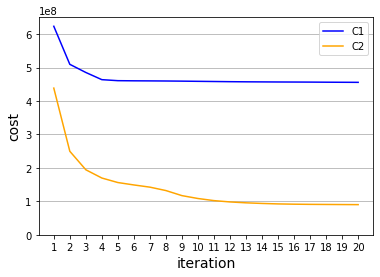

In [16]:
plot_costs(costs_c1, costs_c2)

In [17]:
print("c1 percentage improvement: %f" % calc_improvement(costs_c1), "%")
print("c2 percentage improvement: %f" % calc_improvement(costs_c2), "%")

c1 percentage improvement: 26.885383 %
c2 percentage improvement: 79.437750 %


In [18]:
create_table(centroids_c1, metric="euclidean")
create_table(centroids_c1, metric="manhattan")
create_table(centroids_c2, metric="euclidean")
create_table(centroids_c2, metric="manhattan")

C:\Users\user\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,1,2,3,4,5,6,7,8,9,10
1,0,692.158,3490.26,205.75,346.719,512.612,444.731,566.202,1282.77,307.669
2,,0,2798.8,897.659,1038.83,1204.08,1136.33,1257.45,669.89,412.076
3,,,0,3695.11,3836.91,4002.69,3934.87,4056.14,2294.58,3195.92
4,,,,0,142.439,309.506,241.73,363.263,1474.95,504.634
5,,,,,0,167.15,99.5455,220.902,1615.85,646.931
6,,,,,,0,67.9119,53.7899,1782.2,814.076
7,,,,,,,0,121.634,1715.25,746.336
8,,,,,,,,0,1835.64,867.823
9,,,,,,,,,0,975.32
10,,,,,,,,,,0


,1,2,3,4,5,6,7,8,9,10
1,0,728.924,3797.9,212.181,374.89,577.402,499.158,645.77,1731.06,406.701
2,,0,3072.89,935.885,1100.83,1303.9,1225.35,1372.09,1005.29,490.928
3,,,0,4001.04,4170.3,4372.79,4294.95,4440.72,2513.42,3396.42
4,,,,0,171.365,375.248,296.255,443.498,1934.09,609.749
5,,,,,0,204.523,125.597,272.935,2102.86,779.397
6,,,,,,0,79.4017,69.5899,2306.38,983.02
7,,,,,,,0,147.866,2227.56,904.37
8,,,,,,,,0,2374.55,1050.92
9,,,,,,,,,0,1327.58
10,,,,,,,,,,0


,1,2,3,4,5,6,7,8,9,10
1,0,15760.1,14110.8,9045.32,5567.68,1924.62,1100.86,402.891,2105.44,3169
2,,0,11524.5,6743.88,10192.5,14455.1,14682.5,15362.4,13674.7,12597
3,,,0,9545.88,10883.4,12234,13208,13786.5,12509,11938.4
4,,,,0,3494.22,7718.22,7957.78,8644.81,6947.82,5876.33
5,,,,,0,4404.56,4492.46,5169.94,3488.16,2407.92
6,,,,,,0,1182.86,1615.79,1313.33,2153.77
7,,,,,,,0,698.488,1010.2,2085.46
8,,,,,,,,0,1702.79,2768.61
9,,,,,,,,,0,1080.53
10,,,,,,,,,,0


,1,2,3,4,5,6,7,8,9,10
1,0,15772.6,20215.6,9533.17,5604.2,3088.05,1311.04,471.266,2369.41,3349.66
2,,0,16003.5,7219.2,10221,16105.3,14909.2,15434.5,13950.6,12776.9
3,,,0,10690.5,14613.6,17509.9,18912.6,19748.9,17851.8,16873.2
4,,,,0,3935.29,8896.39,8228.36,9065.4,7168.73,6190.68
5,,,,,0,5893.07,4696.98,5221.25,3737.71,2564.17
6,,,,,,0,1781.82,2619.81,2162.8,3337.75
7,,,,,,,0,840.723,1068.94,2137.79
8,,,,,,,,0,1901.21,2883.73
9,,,,,,,,,0,1176.45
10,,,,,,,,,,0


### Manhattan distance

In [19]:
costs_c1, centroids_c1 = kmeans(file_d="data.txt", file_c="c1.txt", metric="manhattan")

num of datapoints: 4601
num of centroids: 10
iter 1/20, cost: 550117.142000
iter 2/20, cost: 464869.275879
iter 3/20, cost: 470897.382277
iter 4/20, cost: 483914.409173
iter 5/20, cost: 489216.071003
iter 6/20, cost: 487629.668550
iter 7/20, cost: 483711.923214
iter 8/20, cost: 475330.773493
iter 9/20, cost: 474871.238846
iter 10/20, cost: 457232.920115
iter 11/20, cost: 447494.386197
iter 12/20, cost: 450915.012577
iter 13/20, cost: 451250.367073
iter 14/20, cost: 451974.595540
iter 15/20, cost: 451570.364070
iter 16/20, cost: 452739.011366
iter 17/20, cost: 453082.730287
iter 18/20, cost: 450583.670860
iter 19/20, cost: 450368.749317
iter 20/20, cost: 449011.363726


In [20]:
costs_c2, centroids_c2 = kmeans(file_d="data.txt", file_c="c2.txt", metric="manhattan")

num of datapoints: 4601
num of centroids: 10
iter 1/20, cost: 1433739.310000
iter 2/20, cost: 1084488.776965
iter 3/20, cost: 973431.714662
iter 4/20, cost: 895934.592563
iter 5/20, cost: 865128.335294
iter 6/20, cost: 845846.647031
iter 7/20, cost: 827219.582756
iter 8/20, cost: 803590.345601
iter 9/20, cost: 756039.517276
iter 10/20, cost: 717332.902543
iter 11/20, cost: 694587.925253
iter 12/20, cost: 684444.501997
iter 13/20, cost: 674574.747548
iter 14/20, cost: 667409.469916
iter 15/20, cost: 663556.627822
iter 16/20, cost: 660162.777229
iter 17/20, cost: 656041.322295
iter 18/20, cost: 653036.754073
iter 19/20, cost: 651112.426252
iter 20/20, cost: 649689.013184


,C1,C2
Round 1,550117.142000,1.433739e+06
Round 2,464869.275879,1.084489e+06
Round 3,470897.382277,9.734317e+05
Round 4,483914.409173,8.959346e+05
Round 5,489216.071003,8.651283e+05
Round 6,487629.668550,8.458466e+05
Round 7,483711.923214,8.272196e+05
Round 8,475330.773493,8.035903e+05
Round 9,474871.238846,7.560395e+05
Round 10,457232.920115,7.173329e+05


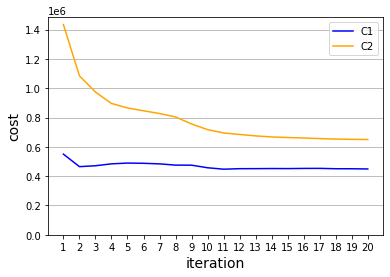

In [21]:
plot_costs(costs_c1, costs_c2)

In [22]:
print("c1 percentage improvement: %f" % calc_improvement(costs_c1), "%")
print("c2 percentage improvement: %f" % calc_improvement(costs_c2), "%")

c1 percentage improvement: 18.378954 %
c2 percentage improvement: 54.685694 %


In [23]:
create_table(centroids_c1, metric="euclidean")
create_table(centroids_c1, metric="manhattan")
create_table(centroids_c2, metric="euclidean")
create_table(centroids_c2, metric="manhattan")

C:\Users\user\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,1,2,3,4,5,6,7,8,9,10
1,0,2219.18,9948.04,528.7,413.365,827.719,681.035,917.127,832.147,729.056
2,,0,7767.95,2734.05,2628.49,3044.48,2898.71,3133.46,1812.45,1491.36
3,,,0,10433.1,10361.4,10773.5,10626.5,10863,9340.28,9236.84
4,,,,0,221.373,375.156,249.379,457.26,1156.58,1251.16
5,,,,,0,415.99,270.749,505.071,1171.96,1137.14
6,,,,,,0,147.047,89.4909,1529.46,1553.12
7,,,,,,,0,236.515,1391.55,1407.4
8,,,,,,,,0,1613.56,1642.13
9,,,,,,,,,0,709.408
10,,,,,,,,,,0


,1,2,3,4,5,6,7,8,9,10
1,0,2341.02,11929.3,651.187,496.332,947.743,770.737,1056.8,1260.51,737.714
2,,0,9597.44,2778.95,2830.14,3280.36,3104.29,3388.98,2380.46,1605.27
3,,,0,12323.3,12421.3,12871.5,12695.6,12979.1,10775.9,11196.8
4,,,,0,335.951,558.469,382.463,667.533,1653.83,1379.17
5,,,,,0,452.861,276.326,561.849,1755.11,1226.66
6,,,,,,0,177.593,110.218,2205.31,1677.67
7,,,,,,,0,287.43,2028.9,1500.99
8,,,,,,,,0,2314.67,1786.81
9,,,,,,,,,0,1006.37
10,,,,,,,,,,0


,1,2,3,4,5,6,7,8,9,10
1,0,15747.2,14100.1,9032.33,5554.79,2006.7,1338.16,514.627,1571.24,3022.66
2,,0,11524.5,6743.88,10192.5,14474.6,14412.1,15239.9,14328.2,12731.4
3,,,0,9545.88,10883.4,12167.8,13125.4,13684.6,12644,12006.4
4,,,,0,3494.22,7742.63,7694.28,8521.2,7588.4,6009.82
5,,,,,0,4452.97,4219.76,5047.52,4167.64,2542.57
6,,,,,,0,1405.11,1637.73,910.994,2124.26
7,,,,,,,0,827.841,566.551,1684.52
8,,,,,,,,0,1081.38,2511.46
9,,,,,,,,,0,1649.39
10,,,,,,,,,,0


,1,2,3,4,5,6,7,8,9,10
1,0,15757.7,20200.3,9517.67,5588.85,3281.49,1430.21,602.955,2102.55,3211.46
2,,0,16003.5,7219.2,10221,16325.3,14506.5,15336,14980.1,12922.9
3,,,0,10690.5,14613.6,17521.5,18775.1,19602.3,18111.9,16995.1
4,,,,0,3935.29,9116.02,8090.51,8918.81,7771.22,6312.53
5,,,,,0,6110.83,4293.5,5123.07,4768.92,2710.06
6,,,,,,0,1855.58,2682.57,1358.8,3413.04
7,,,,,,,0,833.43,674.828,1784.51
8,,,,,,,,0,1500.82,2614
9,,,,,,,,,0,2062.25
10,,,,,,,,,,0
